In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


read csv from github and filter for only "Match" Data

In [104]:
url = "https://raw.githubusercontent.com/philippdrebes/sda-hockey-c2d/main/data/data.csv"
data = pd.read_csv(url, sep=";", encoding_errors="ignore")
condition = data['Types'] == "Match" 
match_data = data[condition]
match_data = match_data[['Player ID', 'Position', 'Distance / min (m)',   'High Metabolic Power Distance / min (m)', 'Acceleration Load (max.)', 'Speed (max.) (km/h)', 'Speed (Ø) (km/h)', 'Acceleration (max.) (m/s²)', 'Deceleration (max.) (m/s²)', 'Accelerations / min', 'Decelerations / min']]

group dataframe by player id

In [105]:
avg_player = match_data.groupby(['Player ID', 'Position'], as_index=False).mean()

group dataframe by position

In [106]:
avg_position = match_data.groupby('Position', as_index=False).mean()
avg_position = avg_position.drop("Player ID", axis=1)

create df with aggregated values (player values relative to average values of position)

In [107]:
rows = avg_player.shape[0]
values = []

for i in range(rows):
    dict_values = {}
    pos = avg_player.at[i,"Position"]
    dict_values["Player ID"] = avg_player.at[i,"Player ID"]
    for col in avg_player.columns:
        if col != "Player ID" and col != "Position":
            relative = avg_player.at[i, col] / avg_position.loc[avg_position['Position'] == pos, col].values[0]
            dict_values[col] = relative
    values.append(dict_values)

agg_df = pd.DataFrame(values)     
display(agg_df)


    

,Player ID,Distance / min (m),High Metabolic Power Distance / min (m),Acceleration Load (max.),Speed (max.) (km/h),Speed (Ø) (km/h),Acceleration (max.) (m/s²),Deceleration (max.) (m/s²),Accelerations / min,Decelerations / min
0,1,0.854264,0.806769,1.216482,0.982344,0.852632,1.054257,0.999194,1.152063,1.225085
1,2,1.030200,1.099869,0.925963,0.987542,1.029358,0.970863,1.051991,1.007114,0.905914
2,3,0.966634,1.020039,1.134732,1.054561,0.965799,1.056373,1.076881,1.181943,1.049611
3,4,1.075194,1.227692,0.903672,1.049957,1.076320,1.119175,1.138774,0.977143,1.128172
4,5,1.040827,0.982154,0.758487,1.059059,1.038698,1.075031,1.177925,0.926476,1.043683
5,6,1.021189,0.841846,1.355949,0.962840,1.022341,0.955583,0.861315,0.735873,0.534266
6,7,0.927907,0.853538,0.817441,0.982994,0.929103,1.077627,1.179627,0.960254,0.921920
7,8,0.986822,0.958769,1.342750,1.000547,0.985537,1.004920,0.937914,0.791365,0.815067
8,9,1.094832,1.204308,0.703052,0.869547,1.095949,0.815361,0.936212,0.948190,1.016348
9,10,0.977003,0.818462,0.974946,0.992746,0.978176,0.937406,0.811951,0.697270,0.829976


evaluate agg_df and create two dfs (strengths and weaknesses) filtering only top and bottom 3 values per player

In [108]:
cols_for_evaluation = [col for col in agg_df.columns if col != "Player ID"]

# Perform the nlargest calculation on the other columns
strengths_df = (agg_df[cols_for_evaluation]
                  .stack()
                  .groupby(level=0)
                  .nlargest(3)
                  .unstack()
                  .reset_index(level=1, drop=True)
                  .reindex(columns=cols_for_evaluation))

# Reinsert the "Player ID" column into strengths_df
strengths_df.insert(0, 'Player ID', agg_df['Player ID'])

# Perform the nlargest calculation on the other columns
weaknesses_df = (agg_df[cols_for_evaluation]
                  .stack()
                  .groupby(level=0)
                  .nsmallest(3)
                  .unstack()
                  .reset_index(level=1, drop=True)
                  .reindex(columns=cols_for_evaluation))

# Reinsert the "Player ID" column into strengths_df
weaknesses_df.insert(0, 'Player ID', agg_df['Player ID'])

create dictionaries containing the weaknesses and strenghts for each player

In [109]:
rows = strengths_df.shape[0]

strengths_dict = {}
weaknesses_dict = {}

for i in range(rows):
    strengths_dict[strengths_df.at[i, "Player ID"]] = {}
    for col in strengths_df.columns:
        if col != "Player ID" and not np.isnan(strengths_df.loc[i, col]):
            strengths_dict[strengths_df.at[i, "Player ID"]][col] = strengths_df.at[i, col]

for i in range(rows):
    weaknesses_dict[weaknesses_df.at[i, "Player ID"]] = {}
    for col in weaknesses_df.columns:
        if col != "Player ID" and not np.isnan(weaknesses_df.loc[i, col]):
            weaknesses_dict[weaknesses_df.at[i, "Player ID"]][col] = weaknesses_df.at[i, col]
            

create function that retrieves strengths and weaknesses for one player from dictionaries, merges them in a dataframe and adds the reference values of the position group.

In [130]:
def prepare_for_visualization(player_id=2):
    #filter dictionaries based on input variable
    player_strengths = strengths_dict[player_id]
    player_weaknesses = weaknesses_dict[player_id]
    #create dataframes
    strength_df = pd.DataFrame([player_strengths])
    weaknesses_df = pd.DataFrame([player_weaknesses])
    #insert Player ID into dataframes and reorder columns to make sure Player ID is the first columns
    strength_df['Player ID'] = player_id
    weaknesses_df['Player ID'] = player_id
    strength_df = strength_df[['Player ID'] + [col for col in strength_df.columns if col != 'Player ID']]
    weaknesses_df = weaknesses_df[['Player ID'] + [col for col in weaknesses_df.columns if col != 'Player ID']]
    #merge strengths and weaknesses together
    player_df = pd.merge(strength_df, weaknesses_df, on="Player ID", how="inner")
    #lookup position of player
    position = avg_player.loc[avg_player['Player ID'] == player_id, 'Position'].values[0]
    #get values of best player
    condition = avg_player['Position'] == position 
    filtered_df = avg_player[condition]
    relevant_players = filtered_df["Player ID"].tolist()
    condition2= agg_df["Player ID"].isin(relevant_players)
    filtered_df2 = agg_df[condition2]
    row_sums = filtered_df2.iloc[:, 1:].sum(axis=1)
    max_row_index = row_sums.idxmax()
    player_id_with_highest_sum = agg_df.loc[max_row_index, 'Player ID']
    bestval1 = agg_df.loc[agg_df['Player ID'] == player_id_with_highest_sum, player_df.columns[1]].values[0]
    bestval2 = agg_df.loc[agg_df['Player ID'] == player_id_with_highest_sum, player_df.columns[2]].values[0]
    bestval3 = agg_df.loc[agg_df['Player ID'] == player_id_with_highest_sum, player_df.columns[3]].values[0]
    bestval4 = agg_df.loc[agg_df['Player ID'] == player_id_with_highest_sum, player_df.columns[4]].values[0]
    bestval5 = agg_df.loc[agg_df['Player ID'] == player_id_with_highest_sum, player_df.columns[5]].values[0]
    bestval6 = agg_df.loc[agg_df['Player ID'] == player_id_with_highest_sum, player_df.columns[6]].values[0]
    best_player_row = pd.Series(["Best Player",bestval1, bestval2, bestval3, bestval4, bestval5, bestval6], index=player_df.columns)
    player_df = player_df.append(best_player_row, ignore_index=True)
    #add row to dataframe with reference values (reference values are always 1)
    new_row = pd.Series(["avg. Position value",1,1,1,1,1,1], index=player_df.columns)
    player_df = player_df.append(new_row, ignore_index=True)

    return player_df

In [131]:
player_df = prepare_for_visualization()

C:\Users\linus.niederhauser\AppData\Local\Temp\ipykernel_2312\1389610833.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  player_df = player_df.append(best_player_row, ignore_index=True)
C:\Users\linus.niederhauser\AppData\Local\Temp\ipykernel_2312\1389610833.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  player_df = player_df.append(new_row, ignore_index=True)


define function for visualization

In [132]:
def visualization(df=player_df):

    BG_WHITE = "#fbf9f4"
    BLUE = "#2a475e"
    GREY70 = "#b3b3b3"
    GREY_LIGHT = "#f2efe8"
    COLORS = ["#FF5A5F", "#FFB400", "#007A87"]

    # define categories
    CATEGORIES = player_df["Player ID"].values.tolist()

    # define the six variables for the plot
    VARIABLES = player_df.columns.tolist()[1:]
    VARIABLES_N = len(VARIABLES)

    # define the angles at which the values of the numeric variables are placed
    ANGLES = [n / VARIABLES_N * 2 * np.pi for n in range(VARIABLES_N)]
    ANGLES += ANGLES[:1]

    # define padding used to customize the location of the tick labels
    X_VERTICAL_TICK_PADDING = 5
    X_HORIZONTAL_TICK_PADDING = 50    

    # define angle values going from 0 to 2*pi
    HANGLES = np.linspace(0, 2 * np.pi)

    # Used for the equivalent of horizontal lines in cartesian coordinates plots 
    # The last one is also used to add a fill which acts a background color.
    H0 = np.zeros(len(HANGLES))
    H1 = np.ones(len(HANGLES)) * 0.5
    H2 = np.ones(len(HANGLES))

    # Initialize layout ----------------------------------------------
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, polar=True)

    fig.patch.set_facecolor(BG_WHITE)
    ax.set_facecolor(BG_WHITE)

    # Rotate the "" 0 degrees on top. 
    # There it where the first variable, avg_bill_length, will go.
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    # Plot lines and dots --------------------------------------------
    all_values = []
    for idx, species in enumerate(CATEGORIES):
        values = player_df.iloc[idx].drop("Player ID").values.tolist()
        values += values[:1]
        ax.plot(ANGLES, values, c=COLORS[idx], linewidth=4, label=species)
        ax.scatter(ANGLES, values, s=160, c=COLORS[idx], zorder=10)
        for value in values:
            all_values.append(value)
        
    all_values.sort()
    #setting limits for y axis
    ax.set_ylim(all_values[0]*0.9, all_values[-1]*1.1)

    # Set values for the angular axis (x)
    ax.set_xticks(ANGLES[:-1])
    ax.set_xticklabels(VARIABLES, size=14)

    # Remove lines for radial axis (y)
    ax.set_yticks([])

    # Remove spines
    ax.spines["start"].set_color("none")

    #add legends
    handles = [
        Line2D(
            [], [], 
            c=color, 
            lw=3, 
            marker="o", 
            markersize=8, 
            label=species
        )
        for species, color in zip(CATEGORIES, COLORS)
    ]

    legend = ax.legend(
        handles=handles,
        loc=(1, 0),       # bottom-right
        labelspacing=1.5, # add space between labels
        frameon=False     # don't put a frame
    )

    # Iterate through text elements and change their properties
    for text in legend.get_texts():
        text.set_fontsize(16) 

    # Add title 
    fig.suptitle(
        "Radar Plot of Top 3 Player strengths and weaknesses compared to the average and the best player of his Position group",
        x = 0.1,
        y = 1,
        ha="left",
        fontsize=14,
        color=BLUE,
        weight="bold",    
    )

    fig.savefig('C:/Users/linus.niederhauser/OneDrive/2. Semester/SDS/radarplot.png', bbox_inches='tight')
    plt.close(fig)



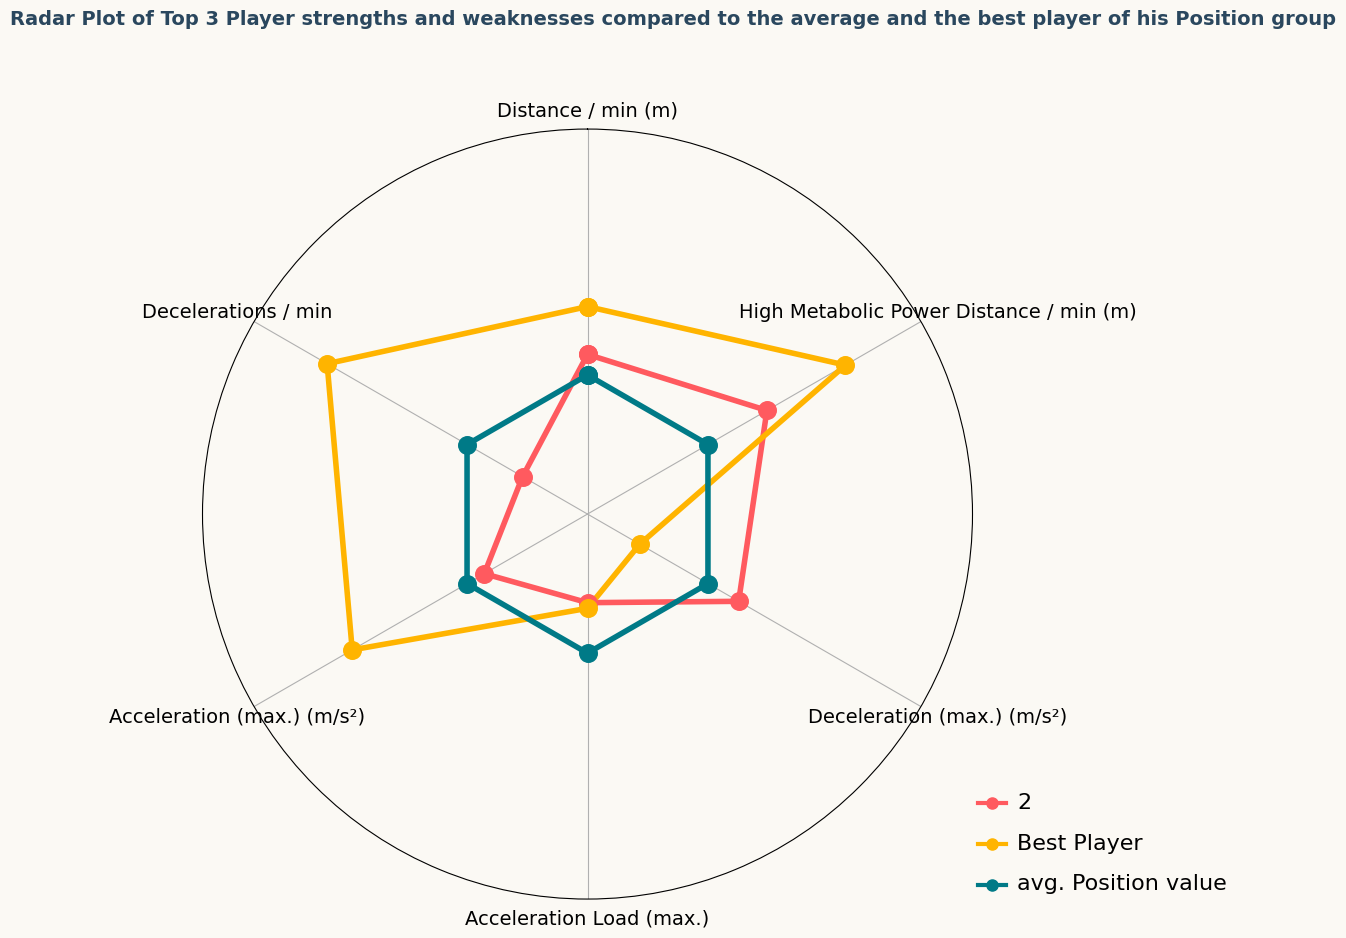

In [133]:
visualization()

create function for description

In [148]:
def description():
    #get player id of current player
    player_id = player_df.at[0, "Player ID"]
    #get strengths and weaknesses (text, values and relative values)
    strengths1_text = player_df.columns[1]
    strengths1_value = "{:.2f}".format(avg_player.loc[avg_player['Player ID'] == player_id, player_df.columns[1]].values[0])
    strenghts1_relative = "{:.2f}".format((player_df.loc[player_df['Player ID'] == player_id, player_df.columns[1]].values[0]-1)*100)
    strengths2_text = player_df.columns[2]
    strengths2_value = "{:.2f}".format(avg_player.loc[avg_player['Player ID'] == player_id, player_df.columns[2]].values[0])
    strenghts2_relative = "{:.2f}".format((player_df.loc[player_df['Player ID'] == player_id, player_df.columns[2]].values[0]-1)*100)
    strengths3_text = player_df.columns[3]
    strengths3_value = "{:.2f}".format(avg_player.loc[avg_player['Player ID'] == player_id, player_df.columns[3]].values[0])
    strenghts3_relative = "{:.2f}".format((player_df.loc[player_df['Player ID'] == player_id, player_df.columns[3]].values[0]-1)*100)
    weakness1_text = player_df.columns[4]
    weakness1_value = "{:.2f}".format(avg_player.loc[avg_player['Player ID'] == player_id, player_df.columns[4]].values[0])
    weakness1_relative = "{:.2f}".format((1-player_df.loc[player_df['Player ID'] == player_id, player_df.columns[4]].values[0])*100)
    weakness2_text = player_df.columns[5]
    weakness2_value = "{:.2f}".format(avg_player.loc[avg_player['Player ID'] == player_id, player_df.columns[5]].values[0])
    weakness2_relative = "{:.2f}".format((1-player_df.loc[player_df['Player ID'] == player_id, player_df.columns[5]].values[0])*100)
    weakness3_text = player_df.columns[6]
    weakness3_value = "{:.2f}".format(avg_player.loc[avg_player['Player ID'] == player_id, player_df.columns[6]].values[0])
    weakness3_relative = "{:.2f}".format((1-player_df.loc[player_df['Player ID'] == player_id, player_df.columns[6]].values[0])*100)
    #create string
    description = f"""
    Your three biggest strengths are:
    \t1. {strengths1_text} with an absolute value of {strengths1_value} which is {strenghts1_relative}% higher than the average of your Position group.
    \t2. {strengths2_text} with an absolute value of {strengths2_value} which is {strenghts2_relative}% higher than the average of your Position group.
    \t3. {strengths3_text} with an absolute value of {strengths3_value} which is {strenghts3_relative}% higher than the average of your Position group.\n
    Your three biggest weaknesses are:
    \t1. {weakness1_text} with an absolute value of {weakness1_value} which is {weakness1_relative}% lower than the average of your Position group.
    \t2. {weakness2_text} with an absolute value of {weakness2_value} which is {weakness2_relative}% lower than the average of your Position group.
    \t3. {weakness3_text} with an absolute value of {weakness3_value} which is {weakness3_relative}% lower than the average of your Position group.
    """
    # Specify the file path where you want to save the text document
    file_path = "C:/Users/linus.niederhauser/OneDrive/2. Semester/SDS/description.txt"
    # Open the file in write mode ('w')
    with open(file_path, 'w') as file:
        # Write the string data to the file
        file.write(description)

In [149]:
description()